# Sensitivity analysis

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to use of Python, [SciPy](https://scipy.org/), [SymPy](http://sympy.org/) and the SALib library for sensitivity analysis. It uses some Python 3 features. Consult the [accompanying lecture slides](https://risk-engineering.org/sensitivity-analysis/) for details of the applications of sensitivity analysis and some intuition and theory of the technique.

In [1]:
import numpy
import scipy.stats
import pandas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

The Rosenbrock function is a classic in uncertainty analysis and sensitivity analysis.

In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms

In [2]:
def rosenbrock(x1, x2):
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2

Since we are lucky enough to be working in a small number of dimensions, let’s plot the function over the domain $[-2, 2]^2$ to get a feel for its shape.

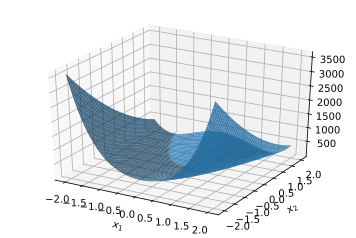

In [20]:
N = 100
fig = plt.figure()
ax = fig.gca(projection='3d')
x = numpy.linspace(-2, 2, N)
y = numpy.linspace(-2, 2, N)
X, Y = numpy.meshgrid(x, y)
ax.plot_surface(X, Y, rosenbrock(X, Y), alpha=0.8)
ax.set_facecolor("white")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$");

## Local sensitivity analysis

We can undertake a local sensitivity analysis by calculating the local derivatives of the Rosenbrock function, with respect to the two input parameters. The local derivatives can be estimated numerically, or calculated analytically (if you know the analytical form of the function you are interested in, and if the function is not excessively difficult to differentiate). 

In this case our Rosenbrock function is easy to differentiate by hand, but let us demonstrate the use of the SymPy package to do symbolic differentiation with the computer. You may need to install the [SymPy](http://sympy.org/) package for your Python installation.

You may be interested in the [minireference.com tutorial on SymPy](http://minireference.com/static/tutorials/sympy_tutorial.pdf).

**Derivatives are perfect sensitivity tools, it is by defintion if I move X1 and or X2 infintelemally what is the effect on Output Y.** And you can obtain these measures analytically instead of numercailly at lower dimensions

In [4]:
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

In [5]:
x1 = sympy.Symbol('x1')
x2 = sympy.Symbol('x2')
rosen = 100 * (x2 - x1**2)**2 + (1 - x1)**2
d1 = sympy.diff(rosen, x1)
d1

         ⎛    2     ⎞           
- 400⋅x₁⋅⎝- x₁  + x₂⎠ + 2⋅x₁ - 2

In [6]:
d2 = sympy.diff(rosen, x2)
d2

        2         
- 200⋅x₁  + 200⋅x₂

The rosenbrock function looks pretty flat around $(0, 0)$; let’s check the local sensitivity in that location. First check $\frac{∂f}{∂x_1}(0, 0)$, then $\frac{∂f}{∂x_2}(0, 0)$

In [7]:
d1.subs({x1: 0, x2: 0})

-2

In [8]:
d2.subs({x1: 0, x2: 0})

0

The function looks much steeper (higher local sensitivity) around $(-2, -2)$; let’s check that numerically.

In [9]:
d1.subs({x1: -2, x2: -2})

-4806

In [10]:
d2.subs({x1: -2, x2: -2})

-1200

At $(-2, 2)$ the sensitivity should be somewhere in between these two points.

In [11]:
d1.subs({x1: -2, x2: 2})

-1606

In [12]:
d2.subs({x1: -2, x2: 2})

-400

We can use SciPy’s optimization functionality to find the minimum of the Rosenbrock function on the domain $[-2, 2]^2$, then check that (as we expect) the local sensitivity at the minimum is zero. The last argument `[2, 2]` to the function `scipy.optimize.fmin` is the starting point of the optimization search.

In [13]:
import scipy
scipy.optimize.fmin(lambda x: rosenbrock(x[0], x[1]), [2, 2])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 119


array([0.99998292, 0.99996512])

The `subs` function in SymPy does variable substitution; it allows you to evaluate an expression with given values for the variables (`x1` and `x2` in this case).

In [14]:
d1.subs({x1: 1, x2: 1})

0

In [15]:
d2.subs({x1: 1, x2: 1})

0

## Global sensitivity analysis

We can use the SALib library (available for download from https://github.com/jdherman/SALib) to undertake a global sensitivity analysis, using the Sobol’ method. You may need to install this library. If you’re using Linux, a command that may work is 

> sudo pip install SALib

or if you’re using Python version 3:

> sudo pip3 install SALib

In [17]:
# this will fail if you haven’t installed the SALib library properly
from SALib.sample import saltelli
from SALib.analyze import sobol

In [18]:
N = 1000
problem = {
    'num_vars': 2, 
    'names': ['x1', 'x2'], 
    'bounds': [[-2, 2], [-2, 2]]
}
sample = saltelli.sample(problem, N)
Y = numpy.empty([sample.shape[0]])
for i in range(len(Y)):
    x = sample[i]
    Y[i] = rosenbrock(x[0], x[1])
sobol.analyze(problem, Y)

{'S1': array([0.49911118, 0.30018188]),
 'S1_conf': array([0.08919942, 0.05743423]),
 'S2': array([[       nan, 0.21626586],
        [       nan,        nan]]),
 'S2_conf': array([[       nan, 0.19527813],
        [       nan,        nan]]),
 'ST': array([0.707303  , 0.51033275]),
 'ST_conf': array([0.09299965, 0.07773807])}

`S1` contains the first-order sensitivity indices, which tell us how much $x_1$ and $x_2$ each contribute to the overall output variability of the rosenbrock function over the domain $[-2, 2]^2$. 

**Interpretation**: we note that $x_1$ (whose sensitivity index is around 0.5) contributes to roughly half of total output uncertainty, and is roughly two times more influential (or sensitive) over this domain than $x_2$. `ST` contains the total indices, which include the interaction effects with other variables. The total sensitivity of $x_1$ (around 0.7) indicates that a significant amount (around 20% (70-50)) of our total output uncertainty is due to the interaction of $x_1$ with other input variables. Since there are only two input variables, we know that this interaction effect must be with $x_2$. 

Some sensitivity analysis methods are also able to provide second and third order sensitivity indices. A second order index $s_{i,j}$ tells you the level of interaction effects between $x_i$ and $x_j$ (interaction effects are greater than zero when your function is non-linear: the sensitivity of parameter $i$ may then depend on the value of parameter $j$). A third order index $s_{i,j,k}$ tells you the level of interaction between three parameters $x_i$, $x_j$ and $x_k$. 

## Exercise

The Ishigami function is a well-known test function for uncertainty analysis and sensitivity analysis (it is highly non-linear). Its definition is given below.

In [21]:
def ishigami(x1, x2, x3) -> float:
    return numpy.sin(x1) + 7*numpy.sin(x2)**2 + 0.1 * x3**4 * numpy.sin(x1)

**Task**: undertake a global sensitivity analysis of the Ishigami function over the domain $[-\pi, \pi]^3$ and estimate the first-order and total sensitivity indices. 